# Filtado de mensajes spam

Se tiene una muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo `datos/spam-sms.zip`.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

In [85]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import nltk
import string

In [86]:
# Lugar para bajar el dataset adecuado
# https://gist.github.com/mydpy/5fb434b1014a6039502faa1e6b6e1d05

## ETL

In [87]:
# Lectura de archivo de mensajes
mensajes = open("datos/SMSSpamCollection","r").readlines()
mensajes[0]

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n'

In [88]:
# remuevo el espacio de tabulación y salto de línea
mensajes = [i.replace("\n","").split("\t") for i in mensajes]

In [89]:
# Separo datos de etiqueta
X = [i[1] for i in mensajes]
y = [0 if i[0] == "ham" else 1 for i in mensajes]

## EDA

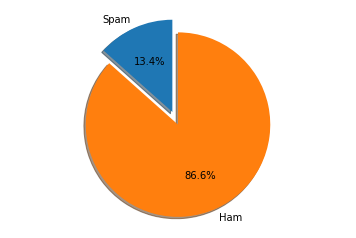

In [90]:
labels = ['Spam','Ham']
sizes = [len(list(filter(lambda i: i == 1, y))), len(list(filter(lambda i: i == 0, y)))]
explode = (0,0.15) 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  
plt.show()

In [91]:
# evidentemnte es un dataset desbalanceado, tengo que hacer stratified sampling en el split de mis datos pa' no sesgar la predicción

In [92]:
# Análisis de spam y ham individualmente para ver su comportamiento
spam_sms = []
ham_sms = []
[spam_sms.append(X[i]) if y[i] == 1 else ham_sms.append(X[i]) for i in range(len(y))]

print("Spam_sms: \n{0}".format(spam_sms[0]),"\n")
print("Ham_sms: \n{0}".format(ham_sms[0]))


Spam_sms: 
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's 

Ham_sms: 
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


C:\Users\andre\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


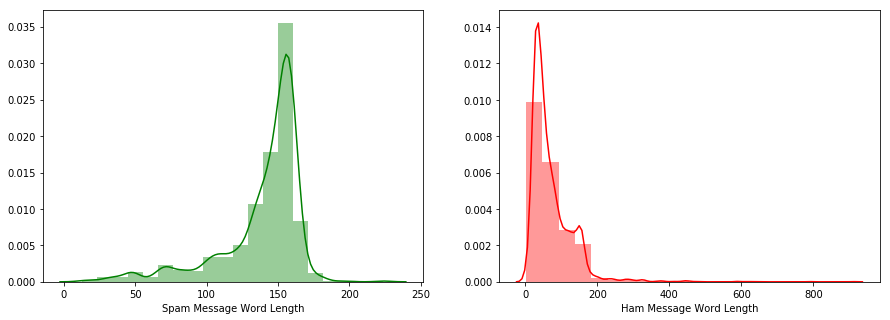

In [93]:
# Tamaño del sms por su tipo

size_spam = [len(i) for i in spam_sms]
size_ham = [len(i) for i in ham_sms]

f, ax = plt.subplots(1, 2, figsize = (15, 5))


sns.distplot(size_spam, bins = 20, ax = ax[0],color="green")
ax[0].set_xlabel("Spam Message Word Length")

sns.distplot(size_ham, bins = 20, ax = ax[1],color="red")
ax[1].set_xlabel("Ham Message Word Length")

plt.show()

In [94]:
# aparentemente los mensajes reales son más corticos que los spam, depronto podría tener peso en la clasificación
# y se podría añadir como una nueva variable de entrada en nuestro data set

## NLP



In [95]:
## Solo lo debo de ejecutar la primera vez que no tenía las stopwords en el paquete
## nltk.download('stopwords')
##

print("Antes de limpiar: {0}".format(X[0]))

stemmer = SnowballStemmer("english")

def cleanText(message):   
    # Remuevo signos de puntuación    
    message = message.translate(str.maketrans('', '', string.punctuation))
    # Minuscula, modo infinitivo, y eliminación de stopwords
    words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]
    # retorno la lista de palabras como un string
    return " ".join(words)
    
X = list(map(cleanText, X))


print("Luego de limpiar: {0}".format(X[0]))



Antes de limpiar: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Luego de limpiar: go jurong point crazi avail bugi n great world la e buffet cine got amor wat


### WordClouds

In [96]:
from os import path
from PIL import Image
from matplotlib.pyplot import figure
import os
import random
from wordcloud import WordCloud,ImageColorGenerator

In [97]:
def plot_word_cloud(datos,image_path):
  
    def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
        return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)  

    d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
    alice_coloring = np.array(Image.open(path.join(d, image_path)))
    wc = WordCloud(background_color="black", max_words=150, mask=alice_coloring,max_font_size=100, random_state=42)
    wc.generate_from_text(" ".join(datos))

    image_colors = ImageColorGenerator(alice_coloring)
    fig, axes = plt.subplots(1, 1)
    axes.imshow(wc.recolor(color_func=grey_color_func, random_state=3), interpolation="bilinear")
    fig.set_size_inches(15,15)
    axes.set_axis_off()
    plt.show()

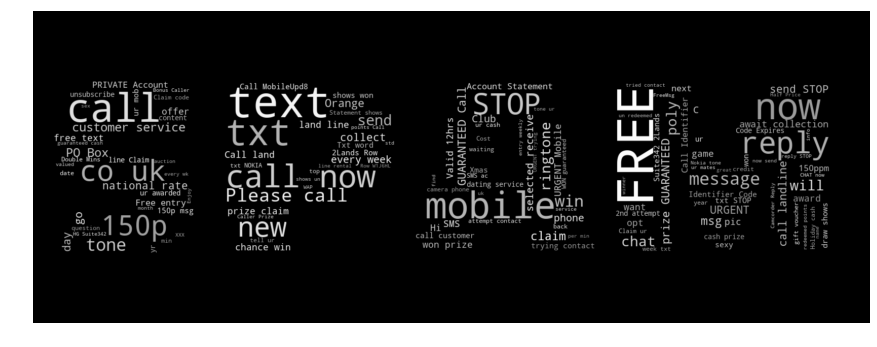

In [98]:
plot_word_cloud(spam_sms,"datos/spam.png")

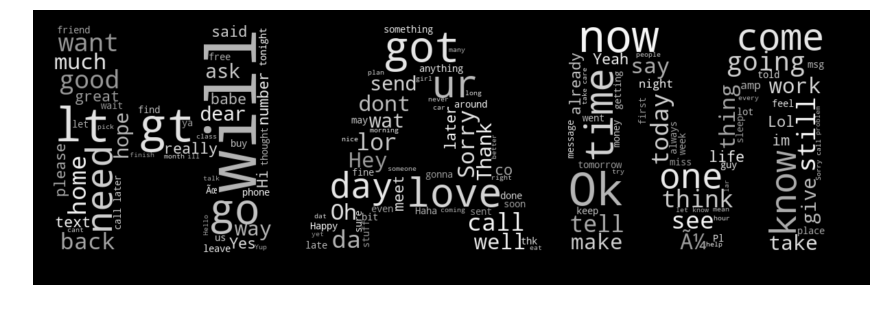

In [99]:
plot_word_cloud(ham_sms,"datos/ham.png")

### DTM (Document term matrix)

In [100]:
from sklearn.feature_extraction.text import CountVectorizer 

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

In [101]:
# 5574 mensajes, y 8098 columnas (cada palabra es una columna)
X.shape

(5574, 8123)

In [102]:
# algunas de las palabras del DTM
vectorizer.get_feature_names()[3000:3010]

['fiendmak',
 'fifa',
 'fifteen',
 'fifth',
 'fifti',
 'fight',
 'fightng',
 'figur',
 'file',
 'fill']

In [103]:
X = X.toarray()

X[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Modelo (Regresión Logística)

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [80]:
# hago una partición stratify por el set tan desbalanceado
X_train, X_test, y_train, y_test = train_test_split(X, y , stratify = y, test_size = 0.3,random_state=101)

In [81]:
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

array([[1445,    4],
       [  32,  192]], dtype=int64)

In [82]:
## Matriz de confusión

confusion_matrix(y_test, y_pred)

array([[1445,    4],
       [  32,  192]], dtype=int64)

In [83]:
## Precisión

print(accuracy_score(y_test, y_pred))

0.9784817692767483


In [84]:
# Precisión: “When it predicts the positive result, how often is it correct?”

# Recall: “When it is actually the positive result, how often does it predict correctly?”

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1449
           1       0.98      0.86      0.91       224

   micro avg       0.98      0.98      0.98      1673
   macro avg       0.98      0.93      0.95      1673
weighted avg       0.98      0.98      0.98      1673



## Keras

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from keras.wrappers.scikit_learn import KerasClassifier

from keras.layers import Dropout


In [0]:
def grid_layers(capas):
    """
    Función para buscar un número aproximado de capas ocultas óptimo, se va a suponer un número de neuronas inicialmente de 5
    70 épocas, y un tamaño del batch de 10 
    """
    param = []

    for i in range(len(capas)):

        classifier = Sequential()

        classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 8098))

        for j in range(capas[i]-1):

            classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

        classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

        classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

        classifier.fit(X_train, y_train, batch_size = 10, epochs = 35)

        y_pred = classifier.predict(X_test)

        y_pred = (y_pred > 0.5)

        cm = confusion_matrix(y_test, y_pred)

        param.append([classifier.summary(),cm,classifier.evaluate(X_test, y_test)])

    return param

layers = [2,5,8,10]

resultado = grid_layers(layers)

In [0]:
# Cómo la diferencia entre 2 capas ocultas y 5 no es muy significativa, así que se seleccionará 2 capas ocultas

resultado

[[None, array([[1448,    1],
         [  27,  197]]), [0.13720903272330828, 0.9832635983263598]],
 [None, array([[1447,    2],
         [  25,  199]]), [0.171090091281692, 0.9838613269575612]],
 [None, array([[1449,    0],
         [ 224,    0]]), [0.3937191961058157, 0.866108786646506]],
 [None, array([[1449,    0],
         [ 224,    0]]), [0.39371893850188017, 0.866108786646506]]]

In [0]:
def grid_neurons(neuronas):
    """
    Función para estimar el número de neuronas por capa (2 hidden layers)
    """    
    param = []
  
    for i in range(len(neuronas)):
    
        classifier = Sequential()

        classifier.add(Dense(units = neuronas[i], kernel_initializer = 'uniform', activation = 'relu', input_dim = 8098))

        classifier.add(Dense(units = neuronas[i], kernel_initializer = 'uniform', activation = 'relu'))

        classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

        classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

        classifier.fit(X_train, y_train, batch_size = 5, epochs = 50)

        y_pred = classifier.predict(X_test)

        y_pred = (y_pred > 0.5)

        cm = confusion_matrix(y_test, y_pred)

        param.append([classifier.summary(),cm,classifier.evaluate(X_test, y_test)])

    return param

neurons = [2,4,8,16,32,64]

resultado_neuronas = grid_neurons(neurons)

In [0]:
resultado_neuronas

[[None, array([[1447,    2],
         [  29,  195]]), [0.17626607703410296, 0.9814704124327556]],
 [None, array([[1448,    1],
         [  27,  197]]), [0.14656849224515753, 0.9832635983263598]],
 [None, array([[1448,    1],
         [  28,  196]]), [0.15092229312389324, 0.9826658696951583]],
 [None, array([[1448,    1],
         [  27,  197]]), [0.15638399994689073, 0.9832635983263598]],
 [None, array([[1449,    0],
         [  21,  203]]), [0.13079231014304388, 0.9874476987447699]],
 [None, array([[1449,    0],
         [  28,  196]]), [0.146888677431952, 0.9832635983263598]]]

In [0]:
def regresor_base(optimizer,activation):
    modelo = Sequential()
    modelo.add(Dense(units = 6, kernel_initializer = 'uniform', activation = activation, input_dim = 8098))
    modelo.add(Dropout(p = 0.1))
    modelo.add(Dense(units = 6, kernel_initializer = 'uniform', activation = activation))
    modelo.add(Dropout(p = 0.1))
    modelo.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    
    modelo.compile(optimizer = optimizer, loss = 'binary_crossentropy' ,metrics = ['accuracy'])
    
    return  modelo

# aquí no le paso ni el batch size ni el numero de epocas porque los voy a buscar con el grid search

regresor = KerasClassifier(build_fn = regresor_base)


#diccionario con los parámetros a  probar
parameters = {'batch_size': [5,10],
              'epochs': [20,50],
              'optimizer': ['adam'],
              'activation':['relu','sigmoid']              
             }

#cv es el numero de folds
grid_search = GridSearchCV(estimator = regresor,
                           param_grid = parameters,
                           cv=2
                           )
grid_search = grid_search.fit(X_train, y_train)

In [0]:
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

In [0]:
best_parameters

{'activation': 'sigmoid', 'batch_size': 5, 'epochs': 50, 'optimizer': 'adam'}

In [0]:
best_accuracy

0.9800051280823282

In [0]:
# voy a volver a tirar la función para ver el número óptimo de neuronas pero con los best_parameters

In [0]:
def grid_neurons(neuronas):
    """
    Función para estimar el número de neuronas por capa (2 hidden layers)
    """    
    param = []
  
    for i in range(len(neuronas)):
    
        classifier = Sequential()

        classifier.add(Dense(units = neuronas[i], kernel_initializer = 'uniform', activation = 'sigmoid', input_dim = 8098))

        classifier.add(Dense(units = neuronas[i], kernel_initializer = 'uniform', activation = 'sigmoid'))

        classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

        classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

        classifier.fit(X_train, y_train, batch_size = 5, epochs = 50)

        y_pred = classifier.predict(X_test)

        y_pred = (y_pred > 0.5)

        cm = confusion_matrix(y_test, y_pred)

        param.append([classifier.summary(),cm,classifier.evaluate(X_test, y_test)])

    return param


neurons = [2,4,8,16,32,64]

resultado_neuronas = grid_neurons(neurons)

In [0]:
resultado_neuronas

[[None, array([[1441,    8],
         [  13,  211]]), [0.12129853589378527, 0.9874476987447699]],
 [None, array([[1437,   12],
         [  11,  213]]), [0.1277021663815715, 0.9862522415179944]],
 [None, array([[1435,   14],
         [  10,  214]]), [0.12609342317793776, 0.985654512886793]],
 [None, array([[1432,   17],
         [   9,  215]]), [0.12137101498233514, 0.9844590556243901]],
 [None, array([[1442,    7],
         [  12,  212]]), [0.11409952036661626, 0.9886431560428002]],
 [None, array([[1446,    3],
         [  17,  207]]), [0.1155565077148408, 0.9880454273759713]]]

In [0]:
neurons

[2, 4, 8, 16, 32, 64]

In [0]:
loss = [i[-1][0] for i in resultado_neuronas]
precission = [i[-1][1] for i in resultado_neuronas]

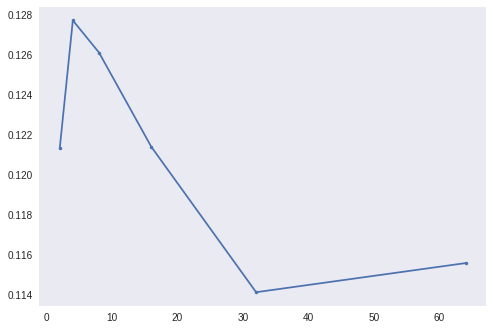

In [0]:
plt.plot(neurons, loss , '.-')
plt.grid()

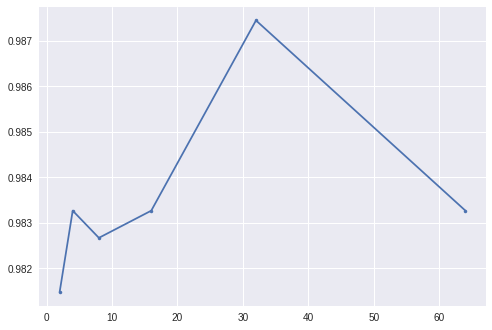

In [0]:
plt.plot(neurons, precission , '.-')

In [41]:
# lA PRECISIÓN MÁS ALTA ES EN 32 Y LA PÉRDIDA MÁS BAJA TAMBIÉN ES AHÍ

In [0]:
## Modelo final
## Menos pérdida y mayor precisipib

In [ ]:
classifier = Sequential()

classifier.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'sigmoid', input_dim = 8098))

classifier.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'sigmoid'))

classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

classifier.fit(X_train, y_train, batch_size = 5, epochs = 150)

y_pred = classifier.predict(X_test)

y_pred = (y_pred > 0.5)

In [0]:
classifier.summary()   

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 32)                259168    
_________________________________________________________________
dense_76 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 33        
Total params: 260,257
Trainable params: 260,257
Non-trainable params: 0
_________________________________________________________________


In [0]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[1441,    8],
       [  11,  213]])

In [0]:
classifier.evaluate(X_test, y_test)

1673/1673 [==============================] - 1s 544us/step


[0.13008231593591513, 0.9886431560428002]

In [0]:
# el de la regression 
array([[1449,    0],
       [  33,  191]])